# init

In [1]:
!pip install neptune 
!pip install lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.2 MB/s eta 0:00:0

In [2]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
# from skimage import io
import pickle
# pytorch related imports
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.optim.lr_scheduler import OneCycleLR
# lightning related imports
import lightning as L
import neptune.new as neptune
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,Lambda


<ipython-input-2-889af393f4ac>:18: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [3]:
import torch
from torchvision import transforms
from PIL import Image

def tensor_to_image(tensor):
    """
    Converts a 3x224x224 PyTorch tensor to an image.
    """
    # Create a transform to convert the tensor to a PIL Image
    transform = transforms.ToPILImage()
    
    # Convert the tensor to a PIL Image
    image = transform(tensor)
    
    # Return the PIL Image
    return image


# download

In [4]:
import os, sys, random, shutil
from google.colab import files

if 'google.colab' in str(get_ipython()):
    # files.upload()
    os.system('mkdir ~/.kaggle')
    os.system('cp drive/MyDrive/studies/kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')
    os.system('kaggle datasets download -d gpiosenka/100-bird-species')
    os.system('unzip 100-bird-species.zip')
    root_address = '.'
else:
    root_address = '../input/100-bird-species'

# model

In [5]:
from re import X
from torchmetrics import Accuracy

class FirstModel(L.LightningModule):
    def __init__(self, train_loader,val_loader,neptun_run=None) -> None:
        super().__init__()
        # self.save_hyperparameters()
        self.train_loader=train_loader
        self.val_loader=val_loader
        self.run=neptun_run
        
        self.val_accuracy = Accuracy(task="multiclass", num_classes=515)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=515)

        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.75)
        self.fc1 = nn.Linear(64*53*53, 1024)
        self.fc2 = nn.Linear(1024, 515)

    def forward(self, x):
        # 3, 224, 224
        x = self.conv1(x)
        x = F.relu(x)
        # 32, 222, 222
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # 64, 110, 110
        x=self.conv3(x)
        x = F.relu(x)
        x=self.conv4(x)
        x = F.relu(x) 
        # 64, 106, 106
        x = self.dropout1(x)
        x = F.max_pool2d(x, 2)
        # 64, 53, 53
        x = torch.flatten(x, 1)
        # 1, 64*53*53
        x = self.fc1(x)
        x = F.relu(x)
        # 1, 1024
        x = self.fc2(x)
        # 1, 515
        output = F.log_softmax(x, dim=1)
        return output

    
    def training_step(self, batch, batch_idx):
        X, y = batch
        loss = F.cross_entropy(self(X),y)
        self.run['train/loss'].append(loss.item())
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=lr)


    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        preds = torch.argmax(logits, dim=1)
        accuracy=self.val_accuracy(preds, y).item()
        loss = F.cross_entropy(logits,y).item()
        if self.run:
          self.run['validation/loss'].append(loss)
          self.run['validation/accuracy'].append(accuracy)
        self.log("val_acc", accuracy , prog_bar=True,on_step=True)
        self.log("val_loss", loss , prog_bar=True,on_step=True)



    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        preds = torch.argmax(logits, dim=1)
        accuracy=self.val_accuracy(preds, y).item()
        loss = F.cross_entropy(logits,y).item()
        if self.run:
          self.run['test/loss'].append(loss)
          self.run['test/accuracy'].append(accuracy)
        self.log("test_acc", accuracy, prog_bar=True,on_step=True)
        self.log("test_loss", loss , prog_bar=True,on_step=True)
    
    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return test_loader

    def int_to_tensor(self,batch_size,y):
      tensor_y = torch.zeros((batch_size,510),dtype=torch.long,device=device) 
      tensor_y[:,y[0].item()]=1
      return tensor_y






In [6]:
def train_model(model,tags):
  trainer = L.Trainer(
    accelerator='auto',
    max_epochs=epochs,
  )
  run = neptune.init_run(
      project="harelmx/deep-hw1",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZDUzNTU3NC0xMzczLTQ4NGQtYTVhOS1jZGJmNzQ3MTA3ZjIifQ==",
  )
  run["sys/tags"].add(tags)
  run["config/lr"]=lr
  run["config/epochs"]=trainer.max_epochs
  run["config/batch_size"]=BATCH_SIZE
  model.run=run
  trainer.fit(model,model.train_loader,model.val_loader)
  print('===vaidate===')
  trainer.validate(model,model.val_loader)
  print(trainer.callback_metrics['val_loss'])
  val_loss=trainer.callback_metrics['val_loss']
  val_acc=trainer.callback_metrics['val_acc']
  print('===test===')
  trainer.test(model,test_loader)
  test_loss=trainer.callback_metrics['test_loss']
  test_acc=trainer.callback_metrics['test_acc']
  run.stop()
  return val_loss, val_acc, test_loss, test_acc, model




In [7]:
BATCH_SIZE = 64
device='cuda'
lr=1e-4
epochs=10

# train_path = 'drive/MyDrive/studies/deep-learning/hw1/data/train'
# val_path = 'drive/MyDrive/studies/deep-learning/hw1/data/valid'
# test_path = 'drive/MyDrive/studies/deep-learning/hw1/data/test'

train_path = './train'
val_path = './valid'
test_path = './test'
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor()])
train_data = ImageFolder(root = train_path,transform=transform)
val_data = ImageFolder(root = val_path,transform=transform)
test_data = ImageFolder(root = test_path,transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)




# model training

In [27]:
model=FirstModel(train_loader,val_loader)
val_loss, val_acc , test_loss, test_acc, model =train_model(model,["firstModel",'regular'])

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-319


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | val_accuracy  | MulticlassAccuracy | 0     
1 | test_accuracy | MulticlassAccuracy | 0     
2 | conv1         | Conv2d             | 896   
3 | conv2         | Conv2d             | 18.5 K
4 | conv3         | Conv2d             | 36.9 K
5 | conv4         | Conv2d             | 36.9 K
6 | dropout1      | Dropout            | 0     
7 | fc1           | Linear             | 184 M 
8 | fc2           | Linear             | 527 K 
-----------------------------------------------------
184 M     Trainable params
0         Non-trainable params
184 M     Total params
738.851   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


===vaidate===


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.5133980512619019     │
│      val_loss_epoch       │    2.6896417140960693     │
└───────────────────────────┴───────────────────────────┘

tensor(2.6896)
===test===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.5281553268432617     │
│      test_loss_epoch      │    2.4811296463012695     │
└───────────────────────────┴───────────────────────────┘

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-319/metadata


# kfold

In [12]:
kfold_train_data= torch.utils.data.ConcatDataset([train_data,val_data])

In [8]:
kf = StratifiedKFold(n_splits=5)
val_loss_lst=[]
val_acc_lst=[]
test_loss_lst=[]
test_acc_lst=[]
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

for i, (train_index, val_index) in enumerate(kf.split(train_data,train_data.targets)):

    train_subset = torch.utils.data.Subset(train_data, train_index)
    val_subset = torch.utils.data.Subset(train_data, val_index)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE,shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE)

    kf_model=FirstModel(train_loader,val_loader)
    val_loss, val_acc , test_loss, test_acc, kf_model =train_model(kf_model,["kfold",f'fold-{i}'])

    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    test_loss_lst.append(test_loss)
    test_acc_lst.append(test_acc)

def mean(lst):
    return sum(lst) / len(lst)


print(f'val_loss_lst mean: {mean(val_loss_lst)}')
print(f'val_acc_lst mean: {mean(val_acc_lst)}')
print(f'test_loss_lst mean: {mean(test_loss_lst)}')
print(f'test_acc_lst mean: {mean(test_acc_lst)}')


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
<ipython-input-6-96c7976f62ab>:6: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-336


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | val_accuracy  | MulticlassAccuracy | 0     
1 | test_accuracy | MulticlassAccuracy | 0     
2 | conv1         | Conv2d             | 896   
3 | conv2         | Conv2d             | 18.5 K
4 | conv3         | Conv2d             | 36.9 K
5 | conv4         | Conv2d             | 36.9 K
6 | dropout1      | Dropout            | 0     
7 | fc1           | Linear             | 184 M 
8 | fc2           | Linear             | 527 K 
-----------------------------------------------------
184 M     Trainable params
0         Non-trainable params
184 M     Total params
738.851   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


===vaidate===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.34100937843322754    │
│      val_loss_epoch       │     3.518331527709961     │
└───────────────────────────┴───────────────────────────┘

tensor(3.5183)
===test===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.42990291118621826    │
│      test_loss_epoch      │    2.7392377853393555     │
└───────────────────────────┴───────────────────────────┘

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-336/metadata


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-337


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | val_accuracy  | MulticlassAccuracy | 0     
1 | test_accuracy | MulticlassAccuracy | 0     
2 | conv1         | Conv2d             | 896   
3 | conv2         | Conv2d             | 18.5 K
4 | conv3         | Conv2d             | 36.9 K
5 | conv4         | Conv2d             | 36.9 K
6 | dropout1      | Dropout            | 0     
7 | fc1           | Linear             | 184 M 
8 | fc2           | Linear             | 527 K 
-----------------------------------------------------
184 M     Trainable params
0         Non-trainable params
184 M     Total params
738.851   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


===vaidate===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.3738289475440979     │
│      val_loss_epoch       │    3.2495291233062744     │
└───────────────────────────┴───────────────────────────┘

tensor(3.2495)
===test===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.47495144605636597    │
│      test_loss_epoch      │    2.4987401962280273     │
└───────────────────────────┴───────────────────────────┘

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 28 operations to synchronize with Neptune. Do not kill this process.
All 28 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-337/metadata


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-338


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | val_accuracy  | MulticlassAccuracy | 0     
1 | test_accuracy | MulticlassAccuracy | 0     
2 | conv1         | Conv2d             | 896   
3 | conv2         | Conv2d             | 18.5 K
4 | conv3         | Conv2d             | 36.9 K
5 | conv4         | Conv2d             | 36.9 K
6 | dropout1      | Dropout            | 0     
7 | fc1           | Linear             | 184 M 
8 | fc2           | Linear             | 527 K 
-----------------------------------------------------
184 M     Trainable params
0         Non-trainable params
184 M     Total params
738.851   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


===vaidate===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │     0.362163782119751     │
│      val_loss_epoch       │    3.2178759574890137     │
└───────────────────────────┴───────────────────────────┘

tensor(3.2179)
===test===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.4563106894493103     │
│      test_loss_epoch      │    2.4875290393829346     │
└───────────────────────────┴───────────────────────────┘

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 26 operations to synchronize with Neptune. Do not kill this process.
All 26 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-338/metadata


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-339


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | val_accuracy  | MulticlassAccuracy | 0     
1 | test_accuracy | MulticlassAccuracy | 0     
2 | conv1         | Conv2d             | 896   
3 | conv2         | Conv2d             | 18.5 K
4 | conv3         | Conv2d             | 36.9 K
5 | conv4         | Conv2d             | 36.9 K
6 | dropout1      | Dropout            | 0     
7 | fc1           | Linear             | 184 M 
8 | fc2           | Linear             | 527 K 
-----------------------------------------------------
184 M     Trainable params
0         Non-trainable params
184 M     Total params
738.851   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


===vaidate===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.32215172052383423    │
│      val_loss_epoch       │    3.6809120178222656     │
└───────────────────────────┴───────────────────────────┘

tensor(3.6809)
===test===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.43495145440101624    │
│      test_loss_epoch      │     2.825756549835205     │
└───────────────────────────┴───────────────────────────┘

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
All 14 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-339/metadata


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-340


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | val_accuracy  | MulticlassAccuracy | 0     
1 | test_accuracy | MulticlassAccuracy | 0     
2 | conv1         | Conv2d             | 896   
3 | conv2         | Conv2d             | 18.5 K
4 | conv3         | Conv2d             | 36.9 K
5 | conv4         | Conv2d             | 36.9 K
6 | dropout1      | Dropout            | 0     
7 | fc1           | Linear             | 184 M 
8 | fc2           | Linear             | 527 K 
-----------------------------------------------------
184 M     Trainable params
0         Non-trainable params
184 M     Total params
738.851   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


===vaidate===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.36139988899230957    │
│      val_loss_epoch       │    3.3078393936157227     │
└───────────────────────────┴───────────────────────────┘

tensor(3.3078)
===test===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.4446601867675781     │
│      test_loss_epoch      │    2.6172287464141846     │
└───────────────────────────┴───────────────────────────┘

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
All 14 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-340/metadata
val_loss_lst mean: 3.3948974609375
val_acc_lst mean: 0.35211071372032166
test_loss_lst mean: 2.6336984634399414
test_acc_lst mean: 0.44815531373023987


# good and bad classification

❌
prediction : IWI , actual : SCARLET MACAW


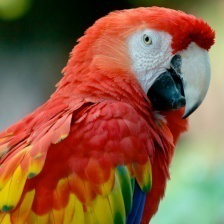

❌
prediction : EMPEROR PENGUIN , actual : FIORDLAND PENGUIN


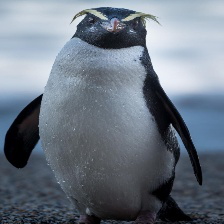

❌
prediction : SNOWY EGRET , actual : WHITE TAILED TROPIC


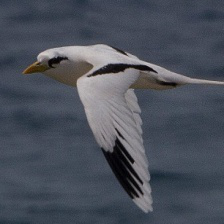

✌
prediction : DOUBLE EYED FIG PARROT , actual : DOUBLE EYED FIG PARROT


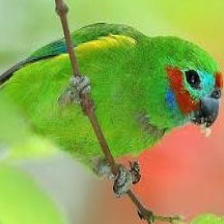

✌
prediction : MALACHITE KINGFISHER , actual : MALACHITE KINGFISHER


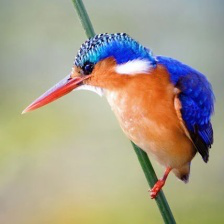

✌
prediction : SCARLET CROWNED FRUIT DOVE , actual : SCARLET CROWNED FRUIT DOVE


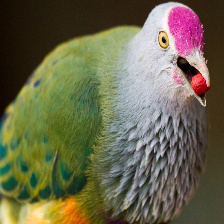

In [28]:
class_dict = {v:k for k,v in val_data.class_to_idx.items()}
max_img = 3
mistake_counter=0
currect_counter=0
good_bad_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE,
                                              shuffle=True
                                              )
for batch_idx, (data, targets) in enumerate(good_bad_loader):
  predictions= model(data)
  predictions = torch.argmax(predictions, dim=1)

  for i in range(len(predictions)):
     
      if targets[i] == predictions[i] and currect_counter<max_img:
          print('====================')
          print("\U0000270C")
          print(f"prediction : {class_dict[predictions[i].item()]} , actual : {class_dict[targets[i].item()]}")
          tensor_to_image(data[i]).show()
          currect_counter+=1
      elif targets[i] != predictions[i] and mistake_counter<max_img:
        print('====================')
        print("\U0000274C")
        print(f"prediction : {class_dict[predictions[i].item()]} , actual : {class_dict[targets[i].item()]}")
        tensor_to_image(data[i]).show()
        mistake_counter+=1
      else:
        break
  if mistake_counter==max_img==currect_counter:
    break


# Better performance

In [8]:
BATCH_SIZE = 32
device='cuda'
lr=1e-4
from re import X
from torchmetrics import Accuracy

class BettertModel(FirstModel):
    def __init__(self, train_loader,val_loader,neptun_run=None) -> None:
        super().__init__(train_loader,val_loader,neptun_run)
      
        self.fc1_2 = nn.Linear(1024, 600)
        self.fc2 = nn.Linear(600, 515)

    def forward(self, x):
        # 3, 224, 224
        x = self.conv1(x)
        x = F.relu(x)
        # 32, 222, 222
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # 64, 110, 110
        x=self.conv3(x)
        x = F.relu(x)
        x=self.conv4(x)
        x = F.relu(x) 
        # 64, 106, 106
        x = self.dropout1(x)
        x = F.max_pool2d(x, 2)
        # 64, 53, 53
        x = torch.flatten(x, 1)
        # 1, 64*53*53
        x = self.fc1(x)
        x = F.relu(x)
        # 1, 1024
        x = self.fc1_2(x)
        # 1,600
        x = self.fc2(x)
        # 1, 515
        output = F.log_softmax(x, dim=1)
        return output






model=BettertModel(train_loader,val_loader)
val_loss, val_acc , test_loss, test_acc, model =train_model(model,["BettertModel"])


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
<ipython-input-6-96c7976f62ab>:6: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-329


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | val_accuracy  | MulticlassAccuracy | 0     
1 | test_accuracy | MulticlassAccuracy | 0     
2 | conv1         | Conv2d             | 896   
3 | conv2         | Conv2d             | 18.5 K
4 | conv3         | Conv2d             | 36.9 K
5 | conv4         | Conv2d             | 36.9 K
6 | dropout1      | Dropout            | 0     
7 | fc1           | Linear             | 184 M 
8 | fc2           | Linear             | 309 K 
9 | fc1_2         | Linear             | 615 K 
-----------------------------------------------------
185 M     Trainable params
0         Non-trainable params
185 M     Total params
740.438   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


===vaidate===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.46912622451782227    │
│      val_loss_epoch       │    2.4567856788635254     │
└───────────────────────────┴───────────────────────────┘

tensor(2.4568)
===test===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │     0.493592232465744     │
│      test_loss_epoch      │    2.3090476989746094     │
└───────────────────────────┴───────────────────────────┘

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 24 operations to synchronize with Neptune. Do not kill this process.
All 24 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-329/metadata


# augmentation

https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-342


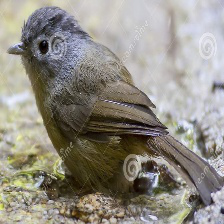

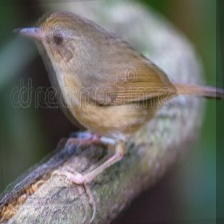

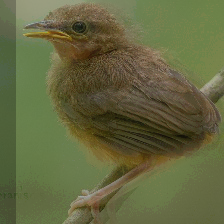

NameError: ignored

In [10]:
import torchvision.transforms as T
from PIL import Image

print_count=3
augmentation_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)               
transformation = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.AugMix(),
                    transforms.ToTensor(),                    
            ])

run = neptune.init_run(
      project="harelmx/deep-hw1",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZDUzNTU3NC0xMzczLTQ4NGQtYTVhOS1jZGJmNzQ3MTA3ZjIifQ==",
  )
run["sys/tags"].add('augmentation')
toPil=transforms.ToPILImage()
acc=Accuracy(task="multiclass", num_classes=515)
for batch_idx, (data, targets) in enumerate(augmentation_loader):
    to_mean=[]
    for r in range(5):
      aug_data = []
      for i in range(data.shape[0]):
          aug_image = transformation(data[i])
          aug_data.append(aug_image)
          if print_count:
            tensor_to_image(aug_image).show()
            print_count-=1

      aug_data = torch.stack(aug_data)
      to_mean.append(aug_data)
    to_mean = torch.stack(to_mean)
    mean_tensor = torch.mean(to_mean, dim=0)
    probs = model(mean_tensor)
    preds = torch.argmax(probs, dim=1)
    accuracy=acc(preds, targets).item()
    run['validation/accuracy'].append(accuracy)
run.stop()

# Add few images of a new category 

In [9]:
class ExtendedClassesModel(FirstModel):
  def __init__(self, train_loader,val_loader,neptun_run=None) -> None:
    super().__init__(train_loader,val_loader,neptun_run)
    self.fc2 = nn.Linear(1024, 516)
    self.val_accuracy = Accuracy(task="multiclass", num_classes=516)
    self.test_accuracy = Accuracy(task="multiclass", num_classes=516)



train_path = './train'
val_path = './valid'
test_path = './test'

train_path_add = 'drive/MyDrive/studies/deep-learning/hw1/data/additional data/train_add'
val_path_add = 'drive/MyDrive/studies/deep-learning/hw1/data/additional data/valid_add'
test_path_add = 'drive/MyDrive/studies/deep-learning/hw1/data/additional data/test_add'

transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor()])

extended_train_data = torch.utils.data.ConcatDataset([ImageFolder(root = train_path,transform=transform),ImageFolder(root = train_path_add,transform=transform)])
extended_val_data = torch.utils.data.ConcatDataset([ImageFolder(root = val_path,transform=transform),ImageFolder(root = val_path_add,transform=transform)])
extended_test_data = torch.utils.data.ConcatDataset([ImageFolder(root = test_path,transform=transform),ImageFolder(root = test_path_add,transform=transform)])

extended_train_loader = torch.utils.data.DataLoader(extended_train_data, batch_size=BATCH_SIZE)
extended_val_loader = torch.utils.data.DataLoader(extended_val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(extended_test_data, batch_size=BATCH_SIZE)

trainer = L.Trainer(
    accelerator='auto',
    max_epochs=epochs,
    # default_root_dir="drive/MyDrive/studies/deep-learning/hw1/models"
)
extendedClassesModel=FirstModel(extended_train_loader,extended_val_loader)

val_loss, val_acc , test_loss, test_acc , extendedClassesModel =train_model(extendedClassesModel,["ExtendedClassesModel"])

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-341


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | val_accuracy  | MulticlassAccuracy | 0     
1 | test_accuracy | MulticlassAccuracy | 0     
2 | conv1         | Conv2d             | 896   
3 | conv2         | Conv2d             | 18.5 K
4 | conv3         | Conv2d             | 36.9 K
5 | conv4         | Conv2d             | 36.9 K
6 | dropout1      | Dropout            | 0     
7 | fc1           | Linear             | 184 M 
8 | fc2           | Linear             | 527 K 
-----------------------------------------------------
184 M     Trainable params
0         Non-trainable params
184 M     Total params
738.851   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


===vaidate===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │   0.0019379844889044762   │
│      val_loss_epoch       │     6.244499206542969     │
└───────────────────────────┴───────────────────────────┘

tensor(6.2445)
===test===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │   0.0019379844889044762   │
│      test_loss_epoch      │     6.244499206542969     │
└───────────────────────────┴───────────────────────────┘

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/harelmx/deep-hw1/e/DEEP1-341/metadata
